# Markowitz portfolio optimization model using Python

The Markowitz model is a portfolio optimization model, modern portfolio theory states that investors can construct optimal portfolios offering the maximum possible expected return for a given level of risk. So the efficient portfolio is that that has the highest reward for a given level of risk or the lowest risk for a given return.

### Market assumptions

1. Returns are normally distributed - the returns of the stocks are normally distributed with u mean and sigma standard deviation.
2. Investors are risk-averse - investors will take on more risk if they are expecting more return. 
   1. If there is a low risk (bonds) the return is low as well
   2. With higher risk (stocks) the returns are usually higher

### Model assumptions

The investors are not allowed to set up short positions in a security so 100% of the wealth has to be divided among the avaailble assets (stocks) in a way that all positions are long positions.

## Import the required libraries

Our project will require the import of the following libraries:
* `numpy` for mathematical operations
* `yfinance` for the scraping of financial data from the Yahoo Finance website
* `pandas` for data manipulation
* `plt` for data visualisations including the stock market historical data and the efficient frontier
* `optimization` for

In [77]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

## Downloading and visualising the dataset

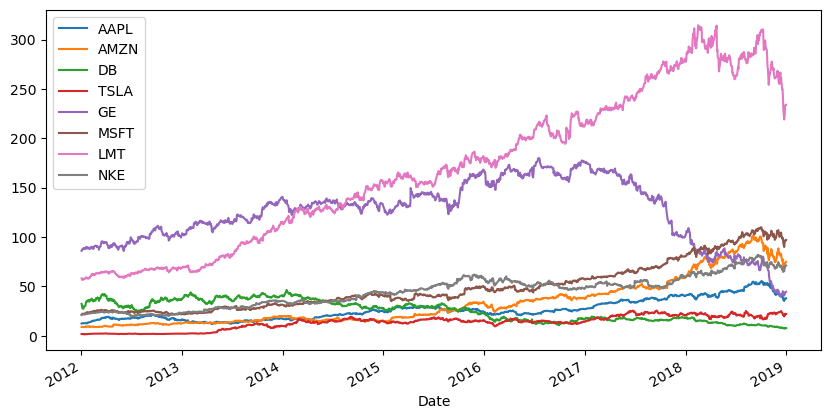

In [78]:
# Stocks we will handle
stocks = ['AAPL', 'AMZN', 'DB', 'TSLA', 'GE', 'MSFT', 'LMT', 'NKE']

# on average 252 trading days in a year
NUM_TRADING_DAYS = 252

# number of portfolios to be generated
NUM_PORTFOLIOS = 10000

# historical data - define START and END date
start_date = '2012-01-01'
end_date = '2019-01-01'

# Download data function
def download_data():
    # name of stock (key) - stock values (2012-2019) as values
    stock_data = {}
    
    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']
        
    return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()


dataset = download_data()
show_data(dataset)

The code above downloads the stock market data, the code starts by defining the stocks we want to download. We then define the start and end dates we want to download our data for. 

In the next section, we define a download_data function, we start by defining a dictionary for stock data with the key as the stock name and the values as the historical prices. We run a loop inside the code, which uses two methods:
* `Ticker` is used as a way to create a Ticker object, we can then be used to obtain financial data for the instrument.
* `history` is used to retrieve the historical prices across a specified time range. We denote `['Close']` to specify that we want the closing price.

The `pd.DataFrame` then converts the stock data into a dataframe.

## Mathematical formulas

There are three main parameters in our model:
* Wi is the weight for the asset or stock
* ri is the return for the i-th asset or stock (historical data) - with the returns we use the either the daily/yearly returns or take the log daily/yearly returns.
* ui is the expected return for the i-th asset or stock (mean of the returns)

### Returns formulas

**Return formula**


$$\text{Return} = \frac{S(t+1) - S(t)}{S(t)}$$


**Logarithmic Returns formula**


$$\text{Log Return} = log(\frac{S(t+1) - S(t)}{S(t)})$$


It is important to use the logarithmic returns as many machine learning techniques require normalization to work effectively.

**Expected returns**

$$\mu_{portfolio} = E(R_{portfolio}) = \mu_p = w^T \mu$$

The `calculate_return` function below calculates the log returns for our dataset, with the `.shift(1)` command moving all the data one point along in the dataset so it now calculates the daily return. We also use the `np.log` function to normalize the data because it makes it more comparable across asset classes and many machine learning models require the data to be **normalised**.

In [79]:
def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metrics
    log_return = np.log(data/data.shift(1))
    return log_return[1:] # Doesn't return the null values from first row

In [80]:
log_daily_returns = calculate_return(dataset)

In [81]:
def show_statistics(returns):
    # Instead of daily returns we get annual metrics
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [82]:
show_statistics(log_returns)

AAPL    0.159300
AMZN    0.304718
DB     -0.203287
TSLA    0.354216
GE     -0.094093
MSFT    0.216522
LMT     0.199270
NKE     0.172895
dtype: float64
          AAPL      AMZN        DB      TSLA        GE      MSFT       LMT  \
AAPL  0.065035  0.026001  0.024469  0.028133  0.014567  0.023754  0.012912   
AMZN  0.026001  0.092073  0.029590  0.042709  0.017282  0.031714  0.014070   
DB    0.024469  0.029590  0.131244  0.033437  0.028023  0.027374  0.016678   
TSLA  0.028133  0.042709  0.033437  0.245997  0.020794  0.028610  0.012971   
GE    0.014567  0.017282  0.028023  0.020794  0.052127  0.016050  0.011881   
MSFT  0.023754  0.031714  0.027374  0.028610  0.016050  0.053164  0.014636   
LMT   0.012912  0.014070  0.016678  0.012971  0.011881  0.014636  0.029287   
NKE   0.015577  0.021625  0.020587  0.026552  0.013393  0.018251  0.012099   

           NKE  
AAPL  0.015577  
AMZN  0.021625  
DB    0.020587  
TSLA  0.026552  
GE    0.013393  
MSFT  0.018251  
LMT   0.012099  
NKE   0.05

### Volatility formulas

The risk of a portfolio can be measured by the volality - that can be approximated by the standard deviation or the variance. Covariance defines how two variables move together, negative covariance means returns move inversely and positive covariance means that asset returns move together.

**Covariance equation**

$$cov(R_{i}, R_{j}) = E[(R_{i} - E(R_{i}))(R_{j} - E(R_{j}))]$$

* Markowitz model is about diversification meaning we want to reduce risk as much as possible.
* Possesing assets with high positive covariance does not provide diversification.
* The aim of diversification is to eliminate fluctuations in the long term.

**Variance equation**

$$\sigma^2(R_{i}) = E[(R_{i} - E(R_{i}))^2] = w^T W$$

For calculating the variance, we need the covariance matrix which contains the relationship between all the assets (in this case stocks) in the portfolio.

In [83]:
def show_mean_variance(returns, weights):
    # Annual portfolio return
    portfolio_return = np.sum(returns.mean()*weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)

## Monte Carlo simulation

In our `generate_portfolios` function we generate random portfolios using loops and random weights. It works as follows:
* First, we define the arrays for the storage of the means, risks and weights from our loops.
* We then use a for loop that runs up the `NUM_PORTFOLIOS` parameter, which in this case is set to 

In [84]:
def generate_portfolios(returns):
    # Arrays for data storage
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []
    
    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))
                               
    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [85]:
weights, means, risks = generate_portfolios(log_daily_returns)

## Efficient frontier

An investor plot each portfolios the expected return against the expected volatility, these portfolio make up the so-called 'efficient frontier'. The efficient frontier is the portfolios which provide the maximum expected return.

This is the main feature of the Markowitz model, the investor can make clear decisions about portfolio based on the risk or expected return. 

In [86]:
def show_portfolios(returns, volatilities):
    # Figure size
    plt.figure(figsize=(18, 6))
    
    # Scatter plot with color according to Sharpe Ratio
    plt.scatter(volatilities, returns, c=returns/volatilities, marker='o')
    
    # Grid
    plt.grid(True)
    
    # Labels
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected return')
    
    # Colorbar
    plt.colorbar(label='Sharpe Ratio')
    
    # Display
    plt.show()

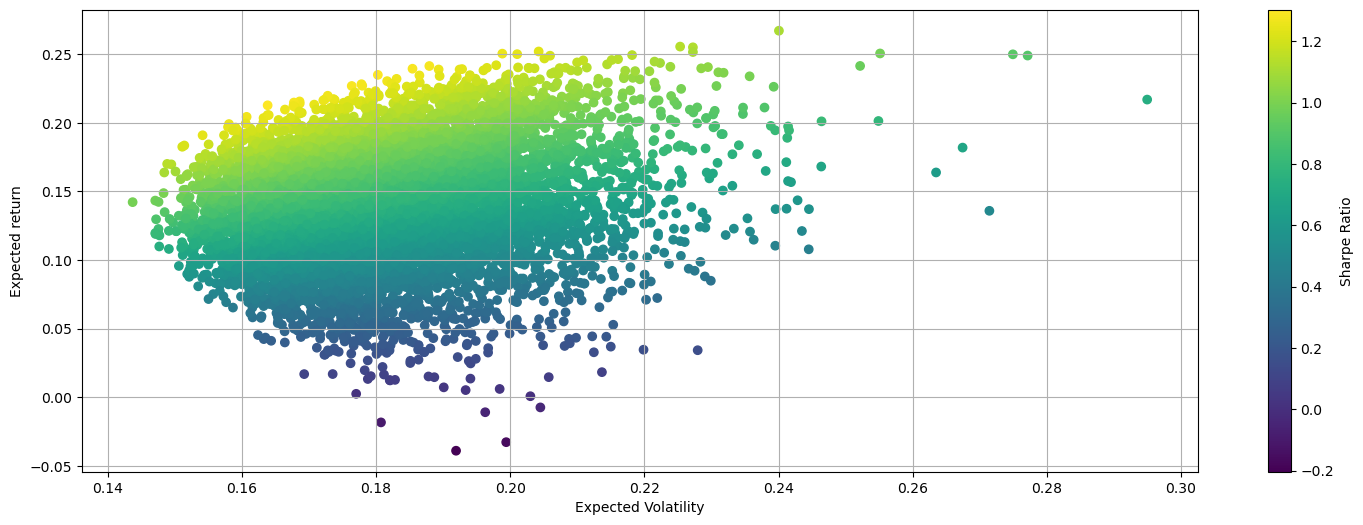

In [88]:
show_portfolios(means, risks)

## Sharpe Ratio

The Sharpe Ratio is one of the most important risk and return measures used in quantitative finance. It describes how much excess return you are receiving for extra volatility that you endure holding a riskier asset (stock).

$$S(x)=\frac{r_{x}-R_{f}}{\sigma(x)}$$

Where:
* Rx is the average rate of return of investment x
* Rf is the rate of return of risk-free security

A Sharpe-ratio **S(X) > 1** it is considered to be good. We can use Sharpe-ratio to compare the portfolios. 

## Capital allocation line

On our graph, we can include risk-free assets as well, usually treasury bills. These portfolios are not on our efficient frontier, therefore we need to consider the capital allocation line, which is the line where the optimal portfolios lie.

On the capital allocation line, if you do not invest all your money in stocks, you are either lending or borrowing money.